In [1]:
# Cell 1: Install Required Libraries (only once in Colab)
!pip install -q pandas scikit-learn matplotlib openpyxl seaborn

In [4]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Cell 3: File Upload (Google Colab)
from google.colab import files
uploaded = files.upload()

Saving tammicomment.xlsx to tammicomment.xlsx


In [6]:
# Cell 4: Load and Prepare Dataset
df = pd.read_excel("tammicomment.xlsx")
df.columns = ['comment', 'ignore', 'label']
df = df[['comment', 'label']].dropna()
df['comment'] = df['comment'].astype(str)

In [8]:
# Label Clean: ক্যাপিটালাইজ করে শুধু তিনটি লেবেল রাখবো
df['label'] = df['label'].str.capitalize()
df = df[df['label'].isin(['Positive', 'Negative', 'Neutral'])]

# Drop missing and convert comment to string
df = df[['comment', 'label']].dropna()
df['comment'] = df['comment'].astype(str)

# চেক করে দেখো সব ঠিক আছে কিনা
print("After cleaning:\n", df['label'].value_counts())

After cleaning:
 label
Positive    4609
Negative    3335
Neutral     2702
Name: count, dtype: int64


In [9]:
# Cell 5: Balance the Dataset (Upsampling)
from sklearn.utils import resample
max_count = df['label'].value_counts().max()
dfs = [resample(df[df.label == label], replace=True, n_samples=max_count, random_state=42)
       for label in df.label.unique()]
df_balanced = pd.concat(dfs)

In [10]:
# Cell 6: Vectorization with TF-IDF
X = df_balanced['comment']
y = df_balanced['label']
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_vect = vectorizer.fit_transform(X)

In [11]:
# Cell 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# Cell 8: Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# Cell 9: Make Predictions
y_pred = rf_model.predict(X_test)

In [14]:
# Cell 10: Evaluation Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8109182935647143

Confusion Matrix:
 [[737 120  65]
 [ 78 760  84]
 [ 81  95 746]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.80      0.81       922
     Neutral       0.78      0.82      0.80       922
    Positive       0.83      0.81      0.82       922

    accuracy                           0.81      2766
   macro avg       0.81      0.81      0.81      2766
weighted avg       0.81      0.81      0.81      2766



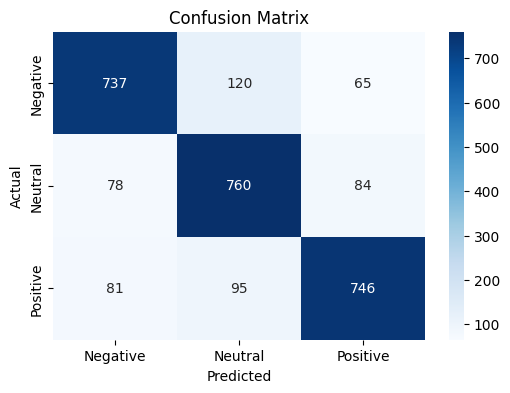

In [15]:
# Cell 11: Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

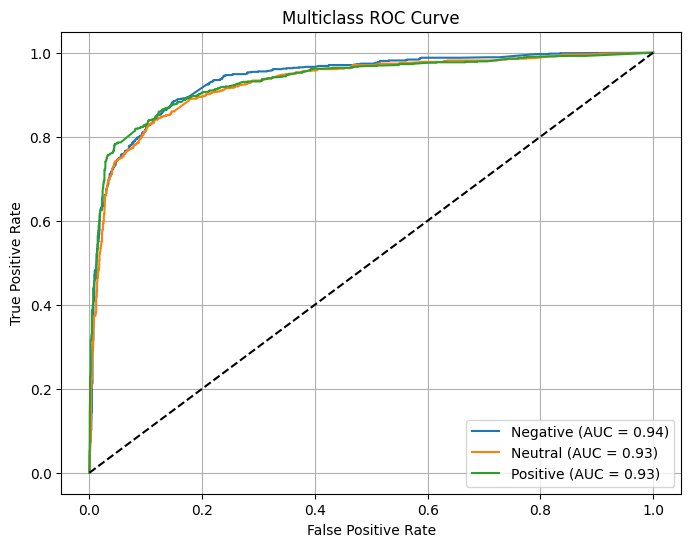

In [16]:
# Cell 12: Multiclass ROC Curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = rf_model.predict_proba(X_test)

plt.figure(figsize=(8,6))
for i, class_name in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_score(y_test_bin[:, i], y_score[:, i]):.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [28]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Dataset with 3 classes: Positive(0), Negative(1), Neutral(2)
X, y = make_classification(n_samples=1000, n_classes=3, n_informative=5, n_clusters_per_class=1, n_redundant=0, random_state=42)
y_bin = label_binarize(y, classes=[0, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_score = model.predict_proba(X_test)

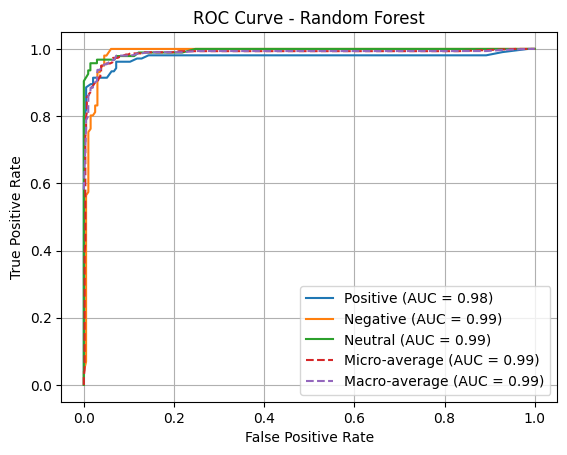

In [29]:
from sklearn.metrics import roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_bin.shape[1]

# Individual class-wise
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[i][:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), np.vstack([y_score[i][:,1] for i in range(n_classes)]).T.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure()
for i, label in enumerate(['Positive', 'Negative', 'Neutral']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle='--')
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid()
plt.show()






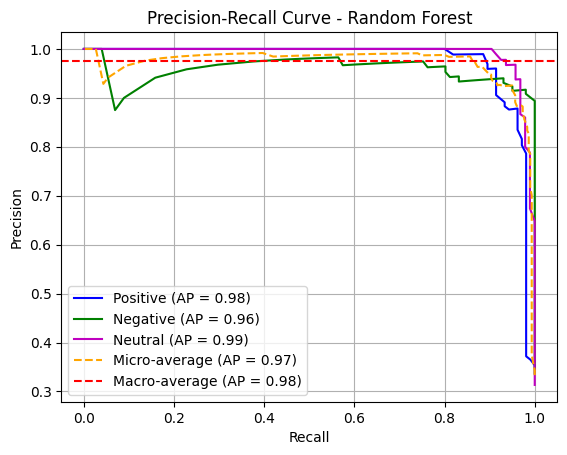

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

precision = dict()
recall = dict()
average_precision = dict()

# Class-wise
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[i][:, 1])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[i][:, 1])

# Micro-average
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(),
    np.vstack([y_score[i][:, 1] for i in range(n_classes)]).T.ravel()
)
average_precision["micro"] = average_precision_score(
    y_test,
    np.array([y_score[i][:, 1] for i in range(n_classes)]).T,
    average="micro"
)

# Macro-average: average of class-wise average precision
average_precision["macro"] = np.mean([average_precision[i] for i in range(n_classes)])

# Plot
plt.figure()
colors = ['b', 'g', 'm']
for i, label in enumerate(['Positive', 'Negative', 'Neutral']):
    plt.plot(recall[i], precision[i], label=f'{label} (AP = {average_precision[i]:.2f})', color=colors[i])

plt.plot(recall["micro"], precision["micro"], label=f'Micro-average (AP = {average_precision["micro"]:.2f})', linestyle='--', color='orange')

# Add macro AP as horizontal line (optional visualization)
plt.axhline(y=average_precision["macro"], linestyle='--', color='red', label=f'Macro-average (AP = {average_precision["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc='lower left')
plt.grid()
plt.show()


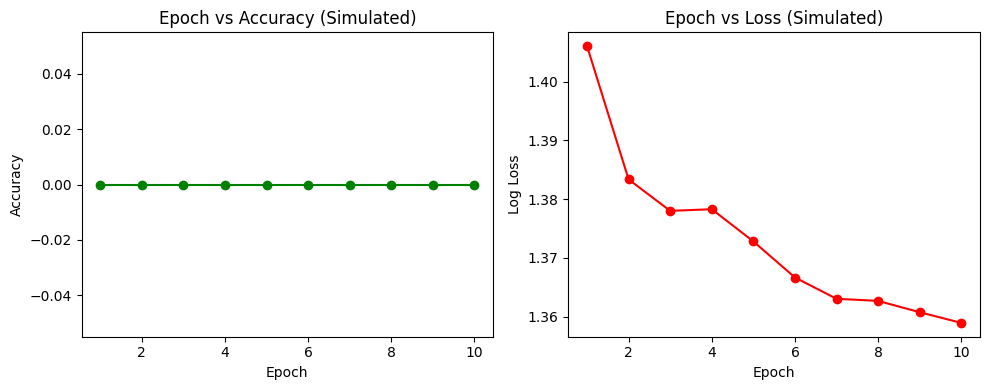

In [60]:
# Simulated Convergence Curve (since Random Forest has no epochs)
train_acc, train_loss = [], []
epochs = 10

for est in range(1, epochs + 1):
    temp_model = RandomForestClassifier(n_estimators=est*3, max_depth=10, random_state=42, n_jobs=-1)
    temp_model.fit(X_train, y_train)
    proba = np.array([m.predict_proba(X_test) for m in temp_model.estimators_])
    avg_proba = np.mean(proba, axis=0)
    pred = np.argmax(avg_proba, axis=1)
    acc = accuracy_score(y_test, pred)
    loss = log_loss(y_test, avg_proba)
    train_acc.append(acc)
    train_loss.append(loss)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_acc, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy (Simulated)')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss, marker='o', color='red')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Epoch vs Loss (Simulated)')

plt.tight_layout()
plt.show()
